In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
yr = 2023
run_no = 1 
rundays = 365
runhours = rundays*24

hr_range = pd.date_range('1/1/'+str(yr)+'', periods=runhours, freq='H') 
day_range = pd.date_range('1/1/'+str(yr)+'', periods=rundays, freq='D')

C:\Users\jerry\AppData\Local\Temp\ipykernel_30120\1305403395.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hr_range = pd.date_range('1/1/'+str(yr)+'', periods=runhours, freq='H')


# Annual generation mix

In [3]:
mwh = pd.read_csv('output/out_Cornell_R'+str(run_no)+'_'+str(yr)+'_mwh.csv',header=0)
hydro = pd.read_csv('output/out_Cornell_R'+str(run_no)+'_'+str(yr)+'_hydro.csv',header=0)
solar = pd.read_csv('output/out_Cornell_R'+str(run_no)+'_'+str(yr)+'_solar.csv',header=0)

###Include Generator_type to the mwh data
df_gen_param = pd.read_csv('input/data_Cornell_genparams.csv',header=0)

gen_name = df_gen_param['name']
gen_type = df_gen_param['typ']

for x in range(len(gen_name)):
    mwh.loc[mwh.Generator == gen_name[x], 'Type'] = gen_type[x]

### Annual generation mix
y_disp = (mwh.groupby(['Type'])['Value'].sum())/1000
y_hydro = sum(hydro['Value'])/1000
y_solar = sum(solar['Value'])/1000

simhydro = y_hydro
simsolar = y_solar
simgas = y_disp['gas']
simslack = y_disp['slack']
simhydrogen = y_disp['hydrogen']
simgeothermal = y_disp['geothermal']

gen = [simhydro, simsolar, simgas, simslack, simhydrogen, simgeothermal]

indx = ['hydro', 'solar', 'gas', 'slack', 'hydrogen', 'geothermal']

df_gen_gwh = pd.DataFrame(gen,columns=['gen'])
df_gen_gwh.index = indx

df_gen_gwh

,gen
hydro,2.349156
solar,85.100752
gas,46.146417
slack,0.000000
hydrogen,0.026269
geothermal,5.018984


# Daily generation mix

In [4]:
types = y_disp.index

###Generations by fuel type and time
disp_hourly = mwh.groupby(['Type','Time'])['Value'].sum()

##Hourly TS of dispatchables
ts_disp_hourly = []
for i in range (len(types)):
    print(types[i])
    ts_disp_hourly.append(pd.Series(disp_hourly[types[i]].values, index=hr_range))


##Daily TS of dispatchables (in GWh)
disp_daily = []
for i in range (len(types)):    
    disp_daily.append(ts_disp_hourly[i].resample('D').sum()/1000)

##Hourly TS of hydro
hydro_hourly = hydro.groupby(['Time'])['Value'].sum()
solar_hourly = solar.groupby(['Time'])['Value'].sum()

ts_hydro = pd.Series(hydro_hourly.values, index=hr_range)
ts_solar = pd.Series(solar_hourly.values, index=hr_range)

##Daily TS of hydro (in GWh)
hydro_daily = ts_hydro.resample('D').sum()/1000
solar_daily = ts_solar.resample('D').sum()/1000

gas
geothermal
hydrogen
slack


# Plot daily generation mix

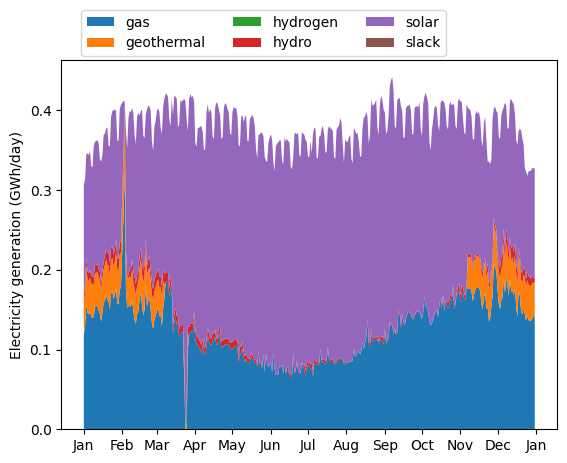

In [5]:
### Plot Daily generation by resource-type
daily_gas = disp_daily[0]
daily_geothermal = disp_daily[1]
daily_hydrogen = disp_daily[2]
daily_slack = disp_daily[3]
daily_hydro = hydro_daily
daily_solar = solar_daily


fig, (ax1) = plt.subplots(nrows=1,ncols=1) ##,figsize=(6,4)

ax1.stackplot(day_range, daily_gas,daily_geothermal,daily_hydrogen,daily_hydro,daily_solar,daily_slack,
              labels=['gas','geothermal','hydrogen','hydro','solar','slack'])
##ax1.set_xticks(rotation=90)
##ax1.set_xlabel('Day')
ax1.set_ylabel('Electricity generation (GWh/day)')
#ax1.set_ylim(0,20.5)
ax1.legend(loc=(0.04,1.01),ncol=3)

# Set the locator
locator = mdates.MonthLocator()  # every month
# Specify the format - %b gives us Jan, Feb...
fmt = mdates.DateFormatter('%b')
X = plt.gca().xaxis
X.set_major_locator(locator)
# Specify formatter
X.set_major_formatter(fmt)

##plt.savefig('fig_daily_generation_curgrid.eps', format='eps',dpi=1200,bbox_inches = "tight") ##

# Annual operating costs

In [6]:
gen_name = df_gen_param['name']
gen_type = df_gen_param['typ']
gen_maxcap = df_gen_param['maxcap']
gen_heat_rate = df_gen_param['heat_rate']
gen_var_om = df_gen_param['var_om']
gen_fix_om = df_gen_param['fix_om']
gen_st_cost = df_gen_param['st_cost']

###Calibrated fuel_prices (from objective function)
fuel_typ = ['gas', 'slack', 'geothermal', 'hydrogen']
cal_fuel_price = [(3.30),53.5604,0,6.82] ##price excluding slack

for x in range(len(fuel_typ)):
    df_gen_param.loc[df_gen_param.typ == fuel_typ[x], 'fu_price'] = cal_fuel_price[x]

fu_price = df_gen_param['fu_price']

df_gen_on = pd.read_csv('output/out_Cornell_R'+str(run_no)+'_2023_on.csv',header=0)
df_gen_switch = pd.read_csv('output/out_Cornell_R'+str(run_no)+'_2023_switch.csv',header=0)

thermo_bygen = (mwh.groupby(['Generator','Time'])['Value'].sum())
on_bygen = (df_gen_on.groupby(['Generator','Time'])['Value'].sum())
switch_bygen = (df_gen_switch.groupby(['Generator','Time'])['Value'].sum())

###Annual total cost by each dispatchable unit
tt_cost_unit = []
fu_cost_unit = []

for i in range(len(gen_name)):
    fx_cost =  gen_maxcap[i]*gen_fix_om[i]*on_bygen[gen_name[i]]
    st_cost =  gen_maxcap[i]*gen_st_cost[i]*switch_bygen[gen_name[i]]
    vr_cost = thermo_bygen[gen_name[i]]*(gen_heat_rate[i]*fu_price[i]+gen_var_om[i])
    fu_cost = thermo_bygen[gen_name[i]]*(gen_heat_rate[i]*fu_price[i])

    tt_cost = fx_cost + st_cost + vr_cost

    tt_cost_unit.append(sum(tt_cost)) ##total cost by each unit
    fu_cost_unit.append(sum(vr_cost))

    
df_tt_cost_unit = pd.DataFrame(tt_cost_unit)
df_tt_cost_unit.index = gen_name
df_tt_cost_unit.columns = ['annual cost ($)']
df_tt_cost_unit

,annual cost ($)
name,
Cornell_CEP,1.018603e+06
NYS_Grid,0.000000e+00
Cornell_CUBO,4.202002e+04
Cornell_Hydrogen,2.498776e+03
